# Wieloboki Voronoi'a

In [1]:
import numpy as np
from bitalg.visualizer.main import Visualizer

**Wizualizacja**

In [36]:
def draw_tri(triangleList):
    vis = Visualizer()
    points = set()
    sides = set()
    for triangle in triangleList:
        a = (triangle.a.x, triangle.a.y)
        b = (triangle.b.x, triangle.b.y)
        c = (triangle.c.x, triangle.c.y)
        points.add(a)
        points.add(b)
        points.add(c)
        sides.add((a, b))
        sides.add((b, c))
        sides.add((c, a))
        
    

    vis.add_point(list(points), color='black')
    vis.add_line_segment(list(sides), color='black')
    vis.show()

def draw_voronoi(triangleList):
    vis = Visualizer()
    points = set()
    sides = set()
    voronoiPoints = set()
    edgeList = {}

    for triangle in triangleList:
        a = triangle.a
        b = triangle.b
        c = triangle.c
        edgeAB = Edge(a, b)
        edgeBC = Edge(b, c)
        edgeCA = Edge(c, a)
        points.add(a.toCart())
        points.add(b.toCart())
        points.add(c.toCart())
        sides.add(edgeAB.toCart())
        sides.add(edgeBC.toCart())
        sides.add(edgeCA.toCart())
        for edge in [edgeAB, edgeBC, edgeCA]:
            if edge in edgeList.keys():
                edgeList[edge].add(triangle)
            else:
                edgeList[edge] = set()
                edgeList[edge].add(triangle)

    for triangle in triangleList:
        a = triangle.a
        b = triangle.b
        c = triangle.c
        edgeAB = Edge(a, b)
        edgeBC = Edge(b, c)
        edgeCA = Edge(c, a)
        voronoiPoint = triangle.getCircleCenter().toCart()
        voronoiPoints.add(voronoiPoint)
        for edge in [edgeAB, edgeBC, edgeCA]:
            if len(edgeList[edge])>1:
                for otherTriangle in edgeList[edge]:
                    if otherTriangle!=triangle:
                        vis.add_line_segment((voronoiPoint, otherTriangle.getCircleCenter().toCart()), color='red')
            else:
                middle = ((edge.A.x+edge.B.x)/2, (edge.A.y+edge.B.y)/2)

                MV = (voronoiPoint[0]-middle[0], voronoiPoint[1]-middle[1])
                if obtuseAngle(triangle, edge):
                    newPoint = (voronoiPoint[0]+MV[0], voronoiPoint[1]+MV[1])
                    vis.add_half_line((voronoiPoint, newPoint),color='red')
                else:
                    vis.add_half_line((voronoiPoint,middle),color='red')
    vis.add_point(list(points), color='black')
    vis.add_line_segment(list(sides), color='black')
    vis.add_point(list(voronoiPoints), color='red')
    vis.show()

**Zbiory danych**

In [3]:
def generate_uniform_points(left, right, n = 10 ** 5):
    tab =[]
    for _ in range(n):
        x = np.random.uniform(left, right)
        y = np.random.uniform(left, right)
        tab.append((x, y))
    return tab

**Funkcje pomocnicze**

In [4]:
# parametr epsilon
eps = 10**-12
def orient(a, b, c):
    return (b.x-a.x)*(c.y-b.y) - (b.y-a.y)*(c.x-b.x)

def findCircumCenter(P, Q, R):
    ax = P[0]
    ay = P[1]
    bx = Q[0]
    by = Q[1]
    cx = R[0]
    cy = R[1]
    d = 2 * (ax * (by - cy) + bx * (cy - ay) + cx * (ay - by))
    ux = ((ax * ax + ay * ay) * (by - cy) + (bx * bx + by * by) * (cy - ay) + (cx * cx + cy * cy) * (ay - by)) / d
    uy = ((ax * ax + ay * ay) * (cx - bx) + (bx * bx + by * by) * (ax - cx) + (cx * cx + cy * cy) * (bx - ax)) / d
    return (ux, uy)

def checkPosition(P, Q, R, D):
    center = findCircumCenter(P, Q, R)
    R = (center[0]-P[0])**2 + (center[1]-P[1])**2
    dist = (center[0]-D[0])**2 + (center[1]-D[1])**2
    return dist-R<=eps

def obtuseAngle(triangle, edge):
    a = edge.A
    b = edge.B
    if triangle.a!=a and triangle.a!=b: c=triangle.a
    if triangle.b!=a and triangle.b!=b: c=triangle.b
    if triangle.c!=a and triangle.c!=b: c=triangle.c
    lengthAB = (a.x-b.x)**2 + (a.y-b.y)**2
    lengthBC = (c.x-b.x)**2 + (c.y-b.y)**2
    lengthCA = (a.x-c.x)**2 + (a.y-c.y)**2
    return lengthAB>lengthBC+lengthCA

**Klasy**

In [5]:
class Point():
    def __init__(self,point,index):
        self.index = index
        self.x = point[0]
        self.y = point[1]

    def __eq__(self, other):
        return self.index==other.index
    
    def __hash__(self):
        return hash(self.index)
    
    def toCart(self):
        return (self.x, self.y)
    
class Edge():
    def __init__(self, PointA, PointB):
        self.A = PointA
        self.B = PointB

    def __eq__(self, other):
        return (self.A==other.A and self.B==other.B) or (self.A==other.B and self.B==other.A)
    
    def __hash__(self):
        return hash(self.A.index+self.B.index)
    
    def toCart(self):
        return ((self.A.x, self.A.y), (self.B.x, self.B.y))


class Triangle():
    def __init__(self,a,b,c):
        self.a = a
        self.b = b
        self.c = c
        self.isCorrect = True

    def __eq__(self, other):
        return self.a==other.a and self.b==other.b and self.c==other.c
    
    def __hash__(self):
        return hash((self.a, self.b, self.c))
    
    def containsPoint(self, point):
        return self.a==point or self.b==point or self.c==point
    
    def circumcircleContainsPoint(self, point):
        P = self.a.toCart()
        Q = self.b.toCart()
        R = self.c.toCart()
        D = point.toCart()
        return checkPosition(P, Q, R, D)
    
    def getCircleCenter(self):
        P = self.a.toCart()
        Q = self.b.toCart()
        R = self.c.toCart()
        return Point(findCircumCenter(P, Q, R),-1)

    def sharesEdge(self, edge):
        x = edge.A
        y = edge.B
        trianglePoints = [self.a, self.b, self.c]
        return x in trianglePoints and y in trianglePoints

**Wizualizacja**

In [38]:
def Bowyer_Watson_with_vis(points):
    lowerX = points[0][0]
    lowerY = points[0][1]
    upperX = points[0][0]
    upperY = points[0][1]
    pointList = []
    n = len(points)
    for i in range(n):
        newPoint = Point(points[i], i)
        pointList.append(newPoint)
        if points[i][0]<lowerX: lowerX = points[i][0]
        if points[i][1]<lowerY: lowerY = points[i][1]
        if points[i][0]>upperX: upperX = points[i][0]
        if points[i][1]>upperY: upperY = points[i][1]


    vis = Visualizer()
    triangleList = []
    # Prostokąt
    lowerX-=100
    lowerY-=100
    upperX+=100
    upperY+=100
    superA = Point((lowerX, lowerY), -2)
    superB = Point((lowerX, upperY), -3)
    superC = Point((upperX, upperY), -4)
    superD = Point((upperX, lowerY), -5)
    vis.add_point([superA.toCart(),superB.toCart(),superC.toCart(),superD.toCart()],color='green')
    vis.show()
    # Dwa trójkąty
    superTriangle1 = Triangle(superA, superB, superC)
    superTriangle2 = Triangle(superC, superD, superA)
    triangleList.append(superTriangle1)
    triangleList.append(superTriangle2)

    # Główna pętla algorytmu
    for point in pointList:
        vis.add_point(point.toCart(),color='black')
        #vis.show()
        # klucz: krawedz, wartość: zbiór trójkątów
        edgeList = {}
        to_delete = []

        to_draw = []
        for triangle in triangleList:
            a = triangle.a
            b = triangle.b
            c = triangle.c
            to_draw+=[(a.toCart(), b.toCart()), (b.toCart(), c.toCart()), (c.toCart(), a.toCart())]
        to_delete.append(vis.add_line_segment(to_draw,color='black')) 
        vis.show()

        to_draw = []
        # Wyznaczenie trójkątów do usunięcia
        for triangle in triangleList:
            if triangle.circumcircleContainsPoint(point):
                triangle.isCorrect=False
                a = triangle.a
                b = triangle.b
                c = triangle.c
                edgeAB = Edge(a, b)
                edgeBC = Edge(b, c)
                edgeCA = Edge(c, a)
                if edgeAB in edgeList.keys():
                    edgeList[edgeAB].add(triangle)
                else:
                    edgeList[edgeAB] = set()
                    edgeList[edgeAB].add(triangle)
                if edgeBC in edgeList.keys():
                    edgeList[edgeBC].add(triangle)
                else:
                    edgeList[edgeBC] = set()
                    edgeList[edgeBC].add(triangle)
                if edgeCA in edgeList.keys():
                    edgeList[edgeCA].add(triangle)
                else:
                    edgeList[edgeCA] = set()
                    edgeList[edgeCA].add(triangle)
                to_draw+=[edgeAB.toCart(), edgeBC.toCart(), edgeCA.toCart()]
        ls = vis.add_line_segment(to_draw, color='red')
        vis.show()
        vis.remove_figure(ls)

        # Usunięcie nieprawidłowych trójkątów
        newTriangleList = []
        for triangle in triangleList:
            if triangle.isCorrect==True: newTriangleList.append(triangle)

        triangleList = newTriangleList
  
        # Usunięcie przecinających się krawędzi
        newEdgeList = dict(edgeList)
        for edge in edgeList.keys():
            if len(edgeList[edge])>1:
                newEdgeList.pop(edge)
        edgeList = newEdgeList
        #ls = vis.add_line_segment(newEdgeList.keys(), color='purple')

        # Utworzenie nowych trójkątów - wypełnienie pustego wielokąta
        for edge in edgeList:
            triangle = Triangle(edge.A, edge.B, point)
            triangleList.append(triangle)

        for fig in to_delete:
            vis.remove_figure(fig)

    finalTriangleList = list(triangleList)
    # usunięcie trójkątów zawierających sztuczne punkty początkowe
    for triangle in triangleList:
        if triangle.containsPoint(superA) or triangle.containsPoint(superB) or triangle.containsPoint(superC) or triangle.containsPoint(superD):
            finalTriangleList.remove(triangle)

    return vis, finalTriangleList

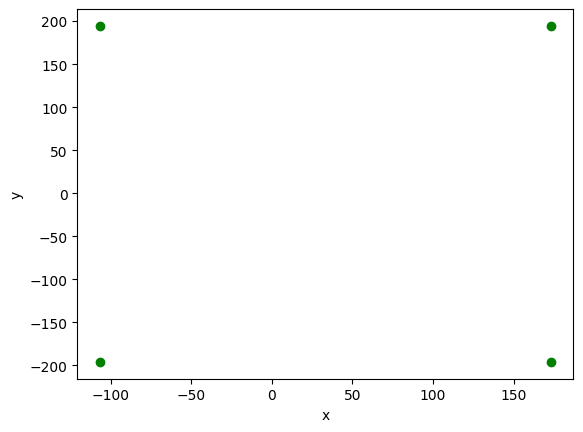

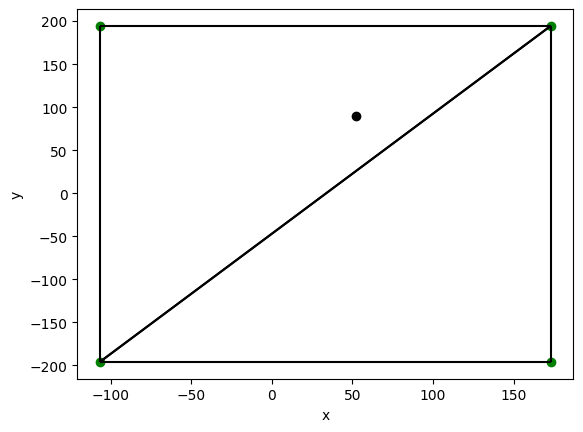

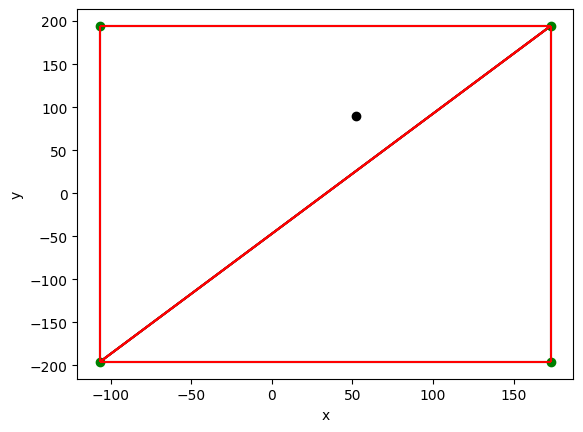

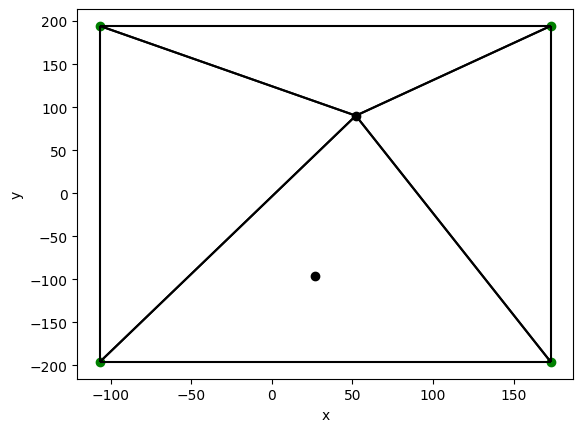

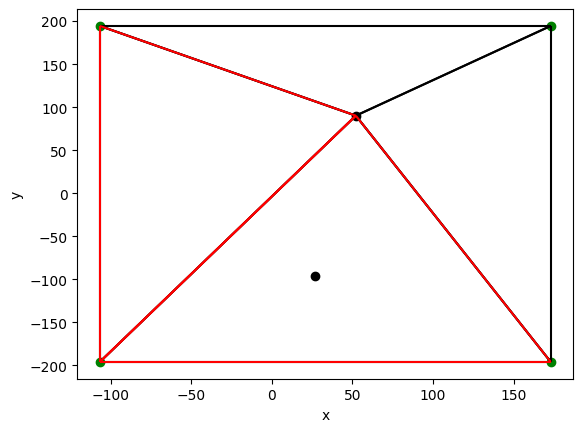

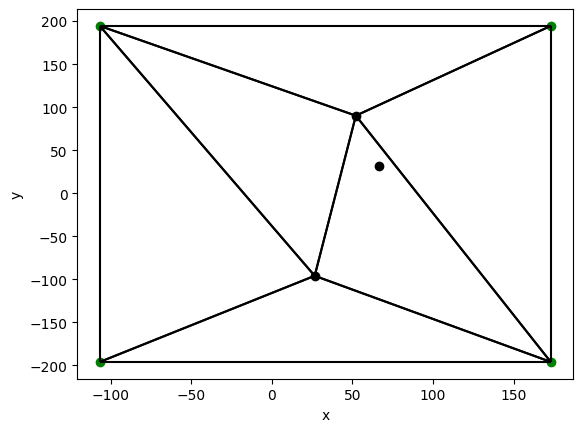

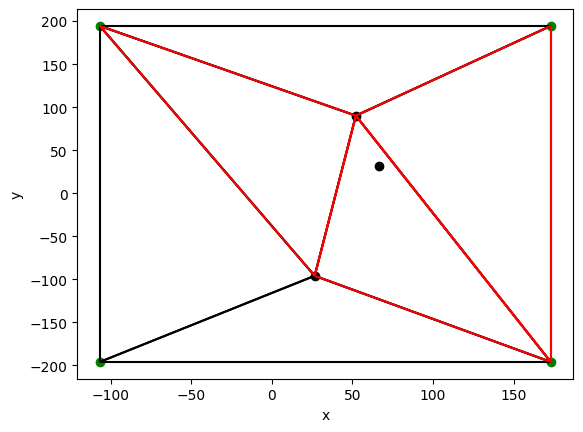

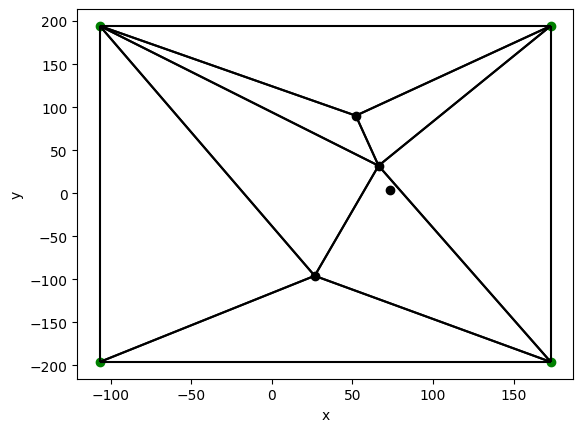

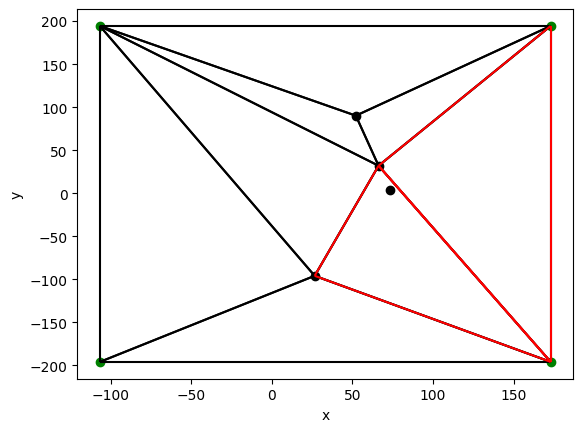

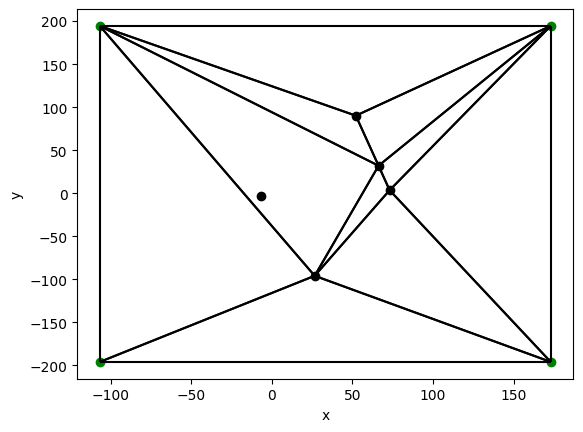

In [43]:
randomPoints = generate_uniform_points(-100, 100, 7)
vis, triangulation = Bowyer_Watson_with_vis(randomPoints)
draw_tri(triangulation)
draw_voronoi(triangulation)
#vis.show_gif(interval=800)

**Główny algorytm**


In [8]:
from algorithms import Bowyer_Watson

def voronoiBowyer_Watson(points):
    '''
    parameters: points = [(x1, y1), (x2, y2), ...]
    return: voronoiPoints = [(a1, b1), (a2, b2), ...]
    '''
    voronoiPoints = []
    triangulation = Bowyer_Watson(points)
    for triangle in triangulation:
        voronoiPoints.append(triangle.getCircleCenter().toCart())
    return voronoiPoints

**Testy algorytmu**

In [10]:
import time
def measure_time(data,n):
    start_time = time.time()
    voronoiPoints = voronoiBowyer_Watson(data)
    print('Bowyer-Watson:','liczba punktów:',n ,'czas:', (time.time() - start_time))

for n in [10, 50, 100, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 10000]:
    randomPoints = generate_uniform_points(-1000, 1000, n)
    measure_time(randomPoints, n)    

    

Bowyer-Watson: liczba punktów: 10 czas: 0.0
Bowyer-Watson: liczba punktów: 50 czas: 0.004274129867553711
Bowyer-Watson: liczba punktów: 100 czas: 0.015915393829345703
Bowyer-Watson: liczba punktów: 500 czas: 0.3201310634613037
Bowyer-Watson: liczba punktów: 1000 czas: 1.2932541370391846
Bowyer-Watson: liczba punktów: 1500 czas: 2.886040449142456
Bowyer-Watson: liczba punktów: 2000 czas: 5.155070543289185
Bowyer-Watson: liczba punktów: 2500 czas: 8.093006372451782
Bowyer-Watson: liczba punktów: 3000 czas: 11.59310507774353
Bowyer-Watson: liczba punktów: 3500 czas: 16.078498363494873
Bowyer-Watson: liczba punktów: 4000 czas: 20.669107675552368
Bowyer-Watson: liczba punktów: 4500 czas: 26.1736319065094
Bowyer-Watson: liczba punktów: 5000 czas: 32.35018587112427
Bowyer-Watson: liczba punktów: 10000 czas: 130.00621271133423
